# Noisy-XOR Dataset Model Comparison

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Generate the Noisy-XOR dataset

In [2]:
def generate_noisy_xor_dataset(
    n_samples, n_features, n_xor_features, noise_level, random_state=None
):
    rng = np.random.RandomState(random_state)

    # Generate random binary features
    X = rng.randint(0, 2, size=(n_samples, n_features))

    # Ensure n_xor_features is not greater than n_features
    if n_xor_features > n_features:
        raise ValueError("n_xor_features cannot be greater than n_features")

    # Calculate y_clean based on the XOR of the first n_xor_features
    if n_xor_features == 0:
        # If no features are designated for XOR, y_clean could be all zeros or random
        # For simplicity, let's make it random if n_xor_features is 0
        y_clean = rng.randint(0, 2, size=n_samples)
    else:
        y_clean = X[:, 0]
        for i in range(1, n_xor_features):
            y_clean = np.logical_xor(y_clean, X[:, i])
        y_clean = y_clean.astype(int)

    # Introduce noise
    n_noise = int(noise_level * n_samples)
    noise_indices = rng.choice(n_samples, size=n_noise, replace=False)

    y = np.copy(y_clean)
    y[noise_indices] = 1 - y[noise_indices]  # Flip the bits

    return X.astype(np.uint8), y.astype(np.uint32)

In [3]:
from sklearn.model_selection import train_test_split


# Generate the dataset with specified parameters
X_data, y_data = generate_noisy_xor_dataset(
    n_samples=1000, n_features=16, n_xor_features=2, noise_level=0.1, random_state=42
)

# Display dataset information
print("Dataset Information:")
print(f"X: {X_data.shape}, {np.unique(X_data)}")
print(f"y: {y_data.shape}, {np.unique(y_data)}")


# Display the first N_DISPLAY_SAMPLES samples
N_DISPLAY_SAMPLES = 5
for x_sample, y_sample in zip(X_data[:N_DISPLAY_SAMPLES], y_data[:N_DISPLAY_SAMPLES]):
    print(f"X: {x_sample}, y: {y_sample}")

# Split the dataset into training and testing sets
X_train_np, X_test_np, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# Define feature names
n_features = X_data.shape[1]
feature_names = [f"feature_{i}" for i in range(n_features)]

# Convert NumPy arrays to Pandas DataFrames
X_train = pd.DataFrame(X_train_np, columns=feature_names)
X_test = pd.DataFrame(X_test_np, columns=feature_names)

# Print proportions of classes in training and testing sets
print("Training set class proportions:")
print(f"  Class 0: {np.mean(y_train == 0):.2f}, Class 1: {np.mean(y_train == 1):.2f}")
print("Testing set class proportions:")
print(f"  Class 0: {np.mean(y_test == 0):.2f}, Class 1: {np.mean(y_test == 1):.2f}")

Dataset Information:
X: (1000, 16), [0 1]
y: (1000,), [0 1]
X: [0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0], y: 1
X: [1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0], y: 0
X: [1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0], y: 0
X: [1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0], y: 0
X: [0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1], y: 1
Training set class proportions:
  Class 0: 0.53, Class 1: 0.47
Testing set class proportions:
  Class 0: 0.53, Class 1: 0.47


## Evaluate the models

In [4]:
from tsetlin_machine_py.c_tsetlin_clf import CTsetlinClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

batch_size = 10
steps = 800
param_grid = {
    "threshold": [1000],
    "num_clauses": [100, 1000],
    "max_state": [127],
    "min_state": [-127],
    "boost_true_positive_feedback": [False],
    "s": [3.0],
}

assert X_train.shape[0] >= steps, (
    f"{batch_size=} * {steps=} exceeds training set size {X_train.shape[0]=}"
)
classes = np.unique(y_train)
print(f"Classes: {classes}")

all_results = {}
for params in (pbar := tqdm(ParameterGrid(param_grid), desc="Grid Search")):
    pbar.set_postfix(params)
    c_tsetlin_clf = CTsetlinClassifier(
        random_state=42,
        **params,
    )

    c_tsetlin_clf.init_empty_state(n_features=X_train.shape[1], classes=classes)

    results = []

    for start_idx in range(0, steps, batch_size):
        end_idx = min(start_idx + batch_size, X_train.shape[0])
        X_train_batch = X_train.iloc[start_idx:end_idx]
        y_train_batch = y_train[start_idx:end_idx]

        c_tsetlin_clf.partial_fit(
            X_train_batch, y_train_batch, classes=classes, epochs=1
        )

        y_train_pred = c_tsetlin_clf.predict(X_train)
        y_test_pred = c_tsetlin_clf.predict(X_test)

        batch_num = start_idx // batch_size + 1
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        results.append(
            {"Batch": batch_num, "Train Accuracy": train_acc, "Test Accuracy": test_acc}
        )

    param_str = ", ".join([f"{k}={v}" for k, v in params.items()])
    all_results[param_str] = pd.DataFrame(results)

Classes: [0 1]


Grid Search: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s, boost_true_positive_feedback=0, max_state=127, min_state=-127, num_clauses=1000, s=3, threshold=1000]


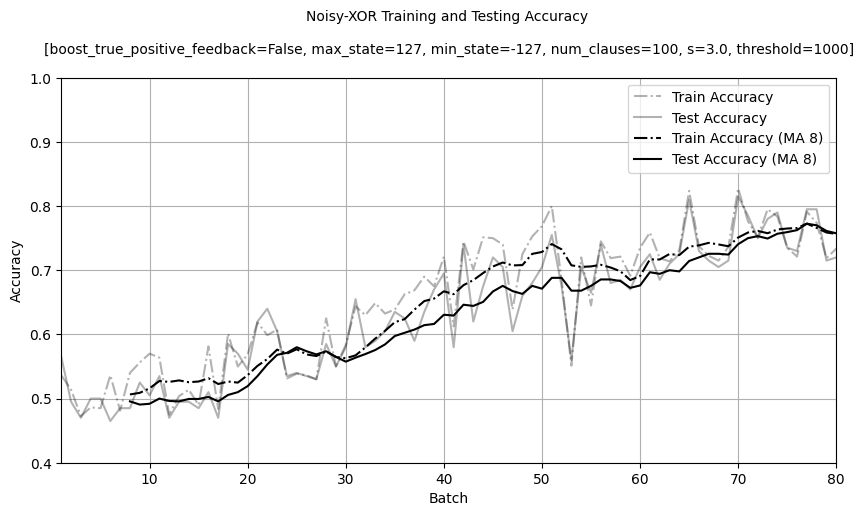

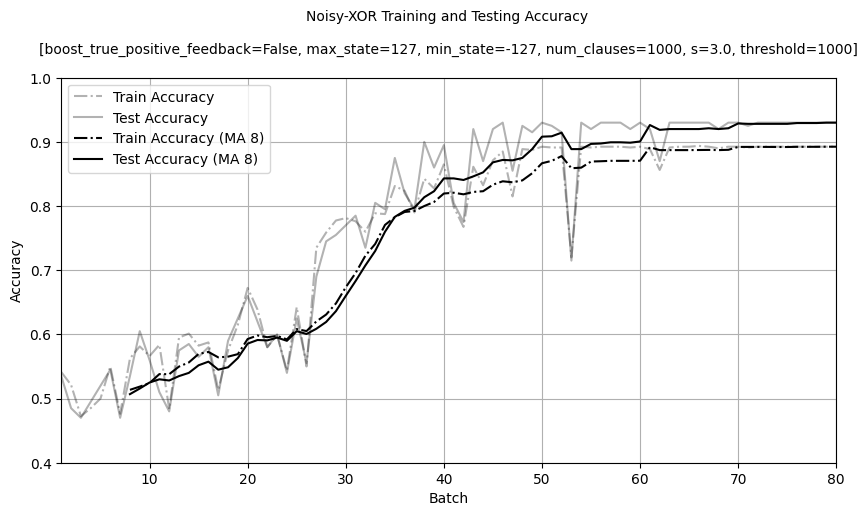

In [5]:
for param_str, df in all_results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df["Batch"], df["Train Accuracy"], label="Train Accuracy", color="black", linestyle="-.", alpha=0.3)
    plt.plot(df["Batch"], df["Test Accuracy"], label="Test Accuracy", color="black", linestyle="-", alpha=0.3)

    plt.plot(df["Batch"], df["Train Accuracy"].rolling(window=8).mean(), label="Train Accuracy (MA 8)", color="black", linestyle="-.")
    plt.plot(df["Batch"], df["Test Accuracy"].rolling(window=8).mean(), label="Test Accuracy (MA 8)", color="black", linestyle="-")

    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.xlim(1, df["Batch"].max())
    plt.ylim(0.4, 1)
    plt.title(f"Noisy-XOR Training and Testing Accuracy \n\n[{param_str}]\n", fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()